# Proyecto 3: Redes Neuronales Multilayer Percetron

## Integrantes:
* Domenic Rincon Espinoza (201920057)
* Christian Rojas Rojas (201710633)
* Juan Jose Leandro Blas (202020096)
* Diego Enciso Lozano (201920157)

In [ ]:
import torch
from torch import nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

cuda0 = torch.device('cuda:0')
print(cuda0)

cuda:0


In [ ]:
%reset


Once deleted, variables cannot be recovered. Proceed (y/[n])? n
Nothing done.
Once deleted, variables cannot be recovered. Proceed (y/[n])? n


# Carga del dataset y split en test y train

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

path = '/content/drive/MyDrive/2023-2/ML/proyecto3/dataset_cancer.csv'

import pandas as pd
data = pd.read_csv(path)

Mounted at /content/drive


In [ ]:
#file_path = 'cancer_dataset.csv'
#data = pd.read_csv(file_path, header=None)

column_names = ["ID", "Diagnosis"] + [f"Feature_{i}" for i in range(1, 31)]
data.columns = column_names

data["Diagnosis"] = data["Diagnosis"].map({"M": 1, "B": 0})

X = data.iloc[:, 2:].values
y = data["Diagnosis"].values

scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

y_train_one_hot = np.zeros((y_train.shape[0], 2))
y_train_one_hot[np.arange(y_train.shape[0]), y_train] = 1

y_test_one_hot = np.zeros((y_test.shape[0], 2))
y_test_one_hot[np.arange(y_test.shape[0]), y_test] = 1

#########################################################################################################################################

X_train = torch.from_numpy(X_train).float()
X_test = torch.from_numpy(X_test).float()
y_test_one_hot = torch.from_numpy(y_test_one_hot).float()
y_train_one_hot = torch.from_numpy(y_train_one_hot).float()

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# Multilayer Perceptron MLP

In [ ]:
class FlexibleMLP(nn.Module):
  def __init__(self, input_size, hidden_layers, hidden_neurons, output_size, hidden_activation, output_activation):
    super(FlexibleMLP, self).__init__()
    self.hidden_activation = hidden_activation
    self.output_activation = output_activation

    layers = []
    layers.append(nn.Linear(input_size, hidden_neurons))
    for i in range(1, hidden_layers):
      layers.append(nn.Linear(hidden_neurons, hidden_neurons))
      layers.append(hidden_activation)

    layers.append(nn.Linear(hidden_neurons, output_size))
    layers.append(output_activation)

    self.mlp = nn.Sequential(*layers)

  def forward(self, x):
    return self.mlp(x)

In [ ]:
def train(model, function, optimizer, epochs, X_train, y_train):
  loss_list = []
  i = 0
  for epoch in range(epochs):

    X_train = X_train.to(device)
    y_pred = model(X_train)
    y_train = y_train.to(device)
    loss = function(y_pred, y_train)
    loss_list.append(loss.item())
    i += 1
    if epoch % 500 == 0:
      print('Epoch {}: train loss: {}'.format(epoch, loss.item()))
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

  return loss_list

## Funcion cambio de parametros para experimentación

In [ ]:
def MLPParameters(numberOfHiddenLayers, numberOfHiddenNeurons):
  # PARAMETERS OF MLP
  input_size = 30
  number_of_hidden_layers = numberOfHiddenLayers
  number_of_hidden_neurons = numberOfHiddenNeurons
  output_size = 2

  activation_hidden = nn.ReLU()
  activation_output = nn.Softmax(dim=1)

  # MODEL
  model1 = FlexibleMLP(input_size, number_of_hidden_layers, number_of_hidden_neurons, output_size, activation_hidden, activation_output).to(device)

  # LOSS
  f_loss = nn.CrossEntropyLoss()

  # HYPERPARAMETERS
  alpha = 0.01
  epochs = 100

  # OPTIMIZER
  optimizer = torch.optim.Adam(model1.parameters(), lr=alpha)

  #TRAIN

  loss_lista = train(model1, f_loss, optimizer, epochs, X_train, y_train_one_hot)

  plt.plot(loss_lista, label='ReLU + Softmax')
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.title('Cross-Entropy-Loss')
  plt.legend()
  plt.show()

  with torch.no_grad():
    #X_test = X_test.to(device)
    y_pred = model1(X_test)
    y_pred = (torch.sigmoid(y_pred) > 0.5).float()

  test_accuracy = accuracy_score(y_test_one_hot.numpy(), (y_pred.cpu()).numpy())


  print(f'Test Accuracy: {test_accuracy:.4f}')

  y_test_classes = np.argmax(y_test_one_hot.numpy(), axis=1)
  y_pred_classes = np.argmax((y_pred.cpu()).numpy(), axis=1)

  # Calcular la matriz de confusión
  conf_matrix = confusion_matrix(y_test_classes, y_pred_classes)

  sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
              xticklabels=['B', 'M'], yticklabels=['B', 'M'])

  plt.title('Matriz de Confusión')
  plt.xlabel('Predicciones')
  plt.ylabel('Valores Reales')
  plt.show()

  return

In [ ]:
with torch.no_grad():
  X_test = X_test.to(device)
  y_pred = model1(X_test)
  y_pred = (torch.sigmoid(y_pred) > 0.5).float()

test_accuracy = accuracy_score(y_test_one_hot.numpy(), (y_pred.cpu()).numpy())


print(f'Test Accuracy: {test_accuracy:.4f}')


Test Accuracy: 0.8947


# Análisis de la información

In [ ]:
# Obtener información general del dataset, como el número de filas y columnas
print("\nInformación general del dataset:")
print(data.info())


Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568 entries, 0 to 567
Data columns (total 32 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   ID          568 non-null    int64  
 1   Diagnosis   568 non-null    int64  
 2   Feature_1   568 non-null    float64
 3   Feature_2   568 non-null    float64
 4   Feature_3   568 non-null    float64
 5   Feature_4   568 non-null    float64
 6   Feature_5   568 non-null    float64
 7   Feature_6   568 non-null    float64
 8   Feature_7   568 non-null    float64
 9   Feature_8   568 non-null    float64
 10  Feature_9   568 non-null    float64
 11  Feature_10  568 non-null    float64
 12  Feature_11  568 non-null    float64
 13  Feature_12  568 non-null    float64
 14  Feature_13  568 non-null    float64
 15  Feature_14  568 non-null    float64
 16  Feature_15  568 non-null    float64
 17  Feature_16  568 non-null    float64
 18  Feature_17  568 non-null    float64


In [ ]:
# Verificar si hay valores nulos o faltantes en el dataset
print("\nValores nulos en el dataset:")
print(data.isnull().sum())


Valores nulos en el dataset:
ID            0
Diagnosis     0
Feature_1     0
Feature_2     0
Feature_3     0
Feature_4     0
Feature_5     0
Feature_6     0
Feature_7     0
Feature_8     0
Feature_9     0
Feature_10    0
Feature_11    0
Feature_12    0
Feature_13    0
Feature_14    0
Feature_15    0
Feature_16    0
Feature_17    0
Feature_18    0
Feature_19    0
Feature_20    0
Feature_21    0
Feature_22    0
Feature_23    0
Feature_24    0
Feature_25    0
Feature_26    0
Feature_27    0
Feature_28    0
Feature_29    0
Feature_30    0
dtype: int64


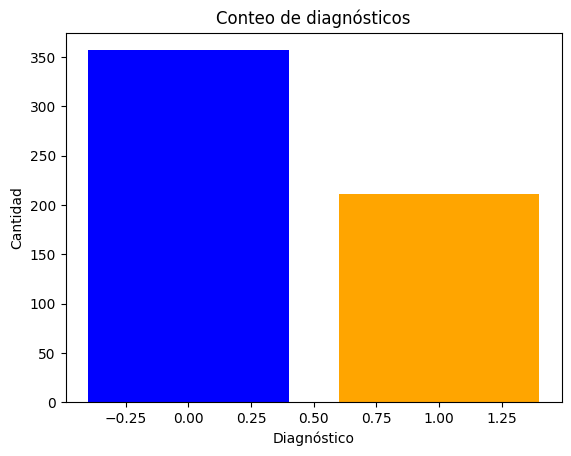


Conteo de diagnósticos:
0    357
1    211
Name: Diagnosis, dtype: int64


In [ ]:
import matplotlib.pyplot as plt

# Conteo de diagnósticos
diagnosis_count = data['Diagnosis'].value_counts()

# Crear un gráfico de barras
plt.bar(diagnosis_count.index, diagnosis_count.values, color=['blue', 'orange'])
plt.title('Conteo de diagnósticos')
plt.xlabel('Diagnóstico')
plt.ylabel('Cantidad')
plt.show()

diagnosis_count = data['Diagnosis'].value_counts()
print("\nConteo de diagnósticos:")
print(diagnosis_count)

# Experimentación

### Cambio de número de capas ocultas

Epoch 0: train loss: 0.6833709478378296


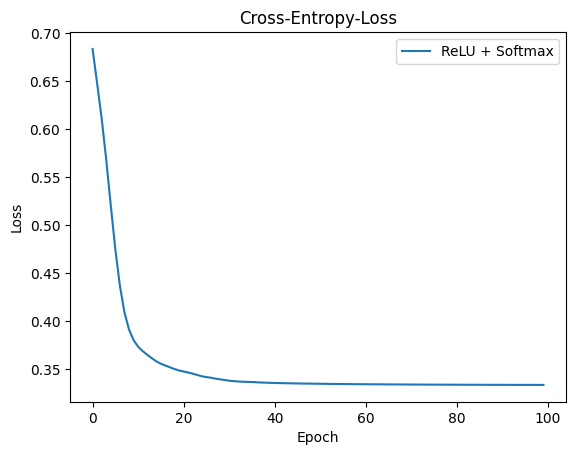

Test Accuracy: 0.7485


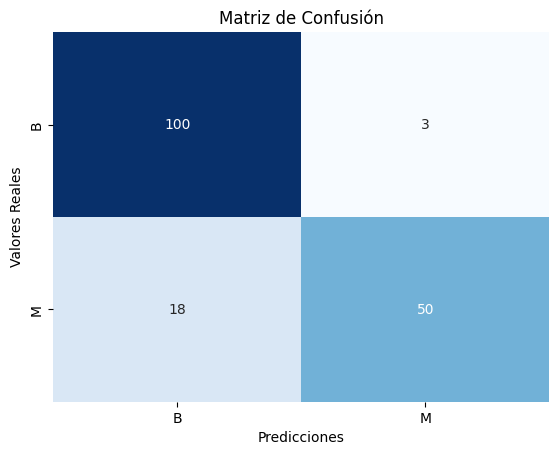

In [ ]:
MLPParameters(2,32)

Epoch 0: train loss: 0.6897859573364258


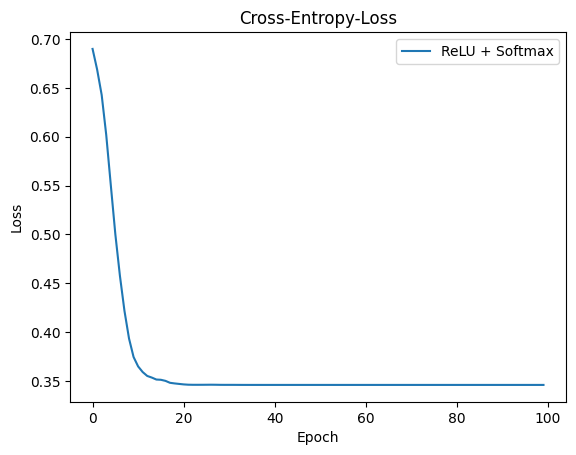

Test Accuracy: 0.8655


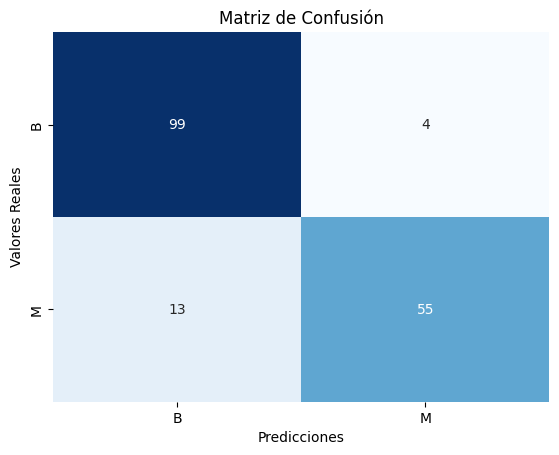

In [ ]:
MLPParameters(4,32)

Epoch 0: train loss: 0.692846953868866


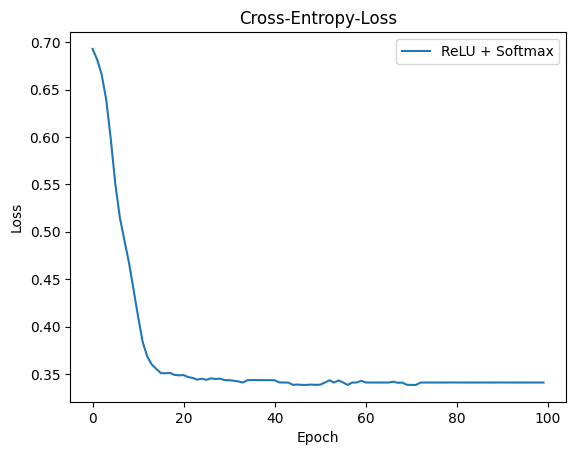

Test Accuracy: 0.8830


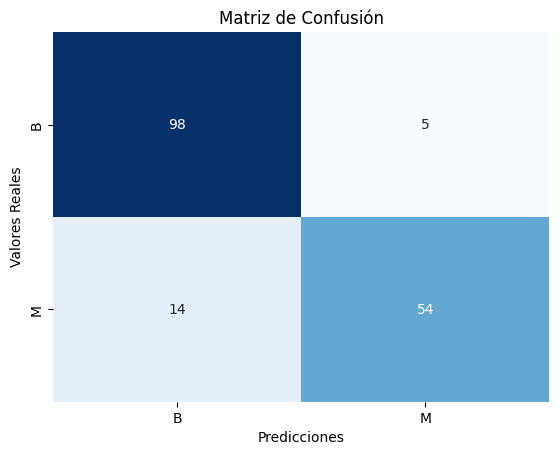

In [ ]:
MLPParameters(5,32)

Epoch 0: train loss: 0.6997565031051636


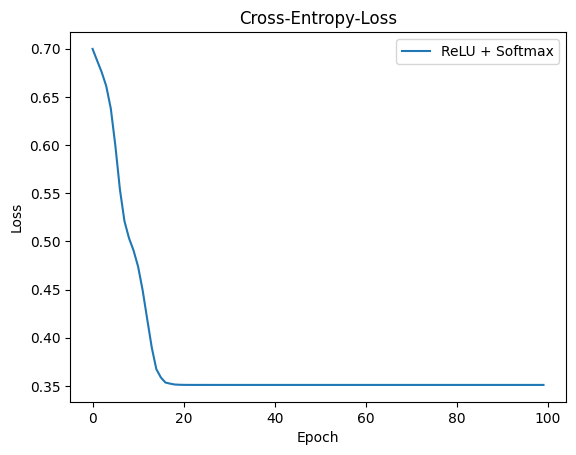

Test Accuracy: 0.8655


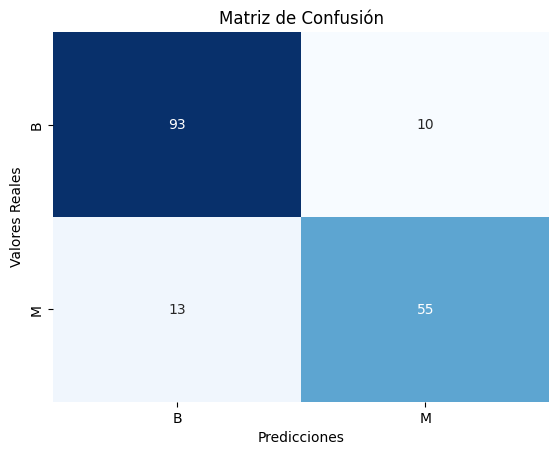

In [ ]:
MLPParameters(6,32)

Epoch 0: train loss: 0.681975781917572


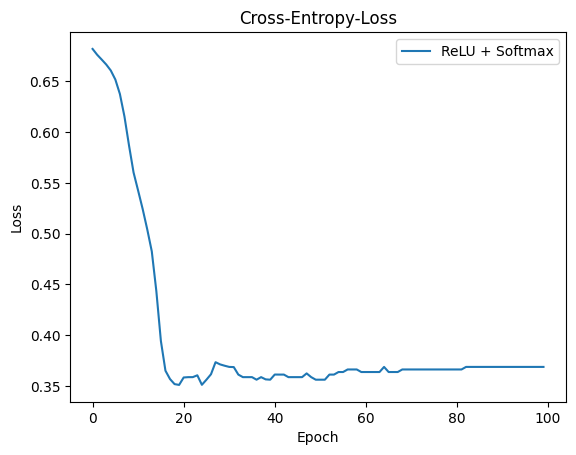

Test Accuracy: 0.8947


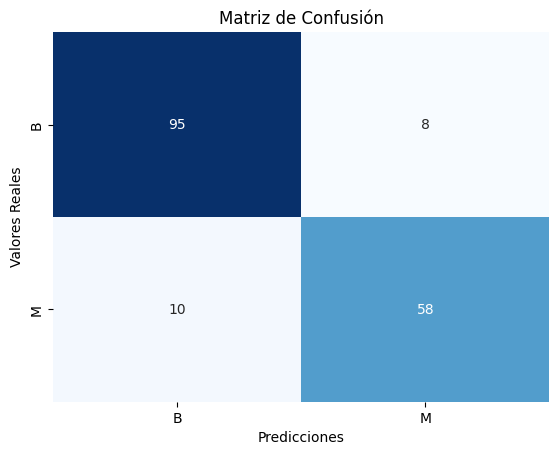

In [ ]:
MLPParameters(8,32)

Epoch 0: train loss: 0.6955277323722839


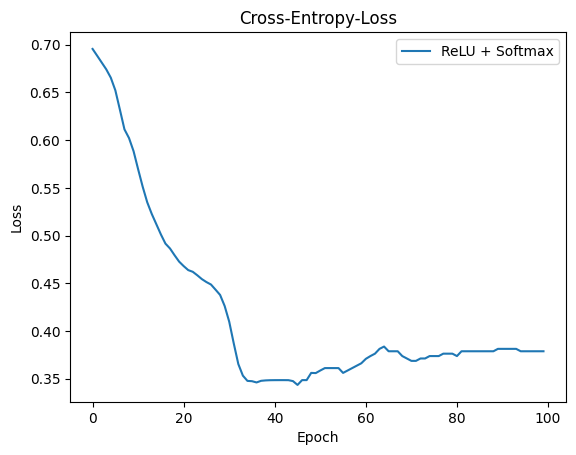

Test Accuracy: 0.9123


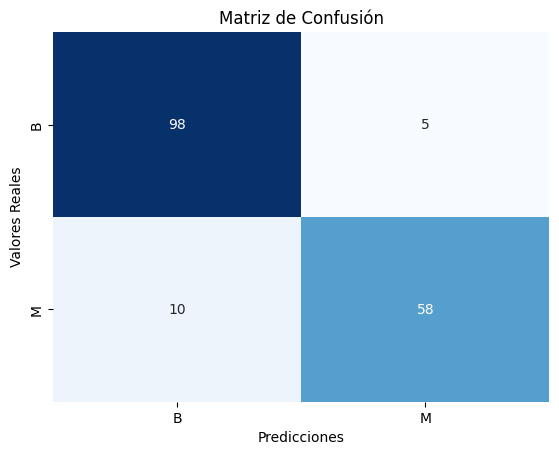

In [ ]:
MLPParameters(10,32)

### Cambio de número de neuronas en la capa oculta

Epoch 0: train loss: 0.681877613067627


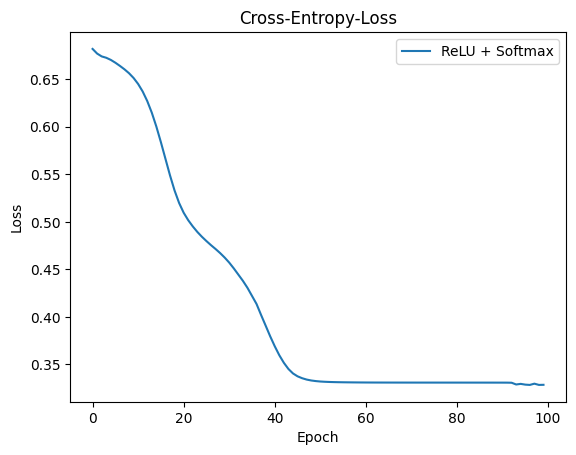

Test Accuracy: 0.7193


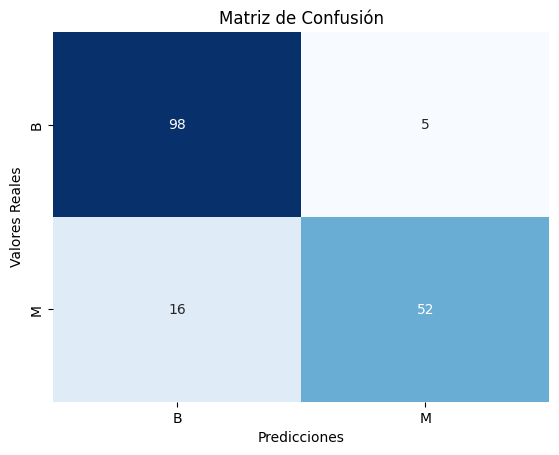

In [ ]:
MLPParameters(5,8)

Epoch 0: train loss: 0.6862189173698425


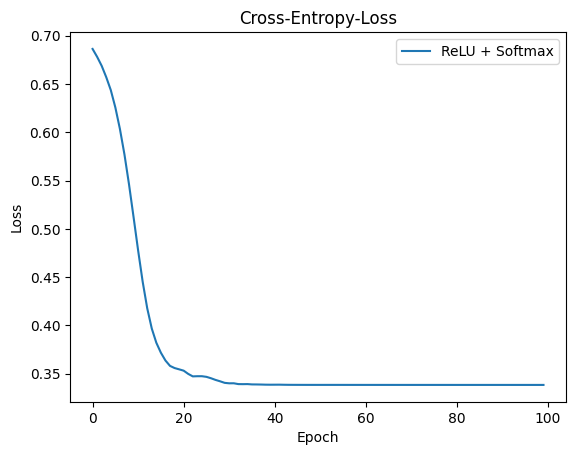

Test Accuracy: 0.8363


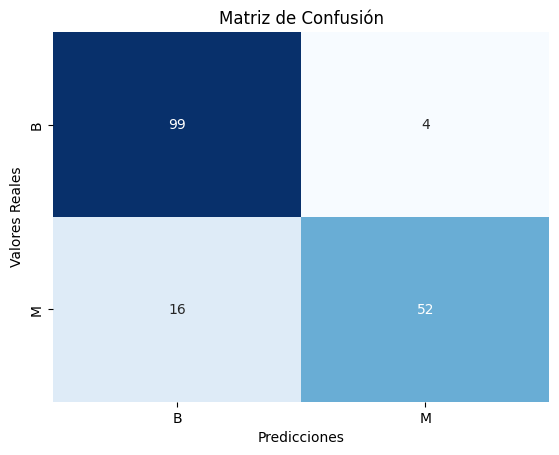

In [ ]:
MLPParameters(5,16)

Epoch 0: train loss: 0.7149651646614075


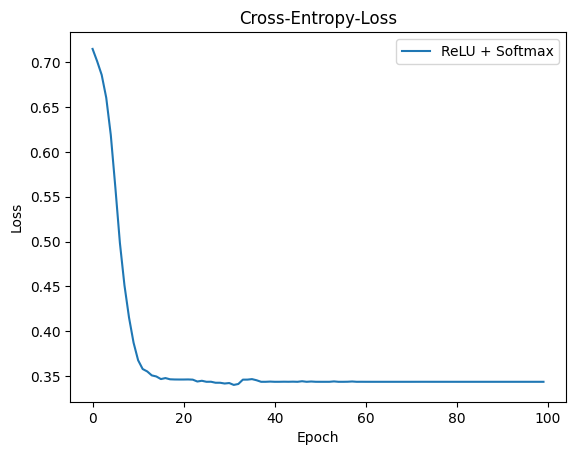

Test Accuracy: 0.8655


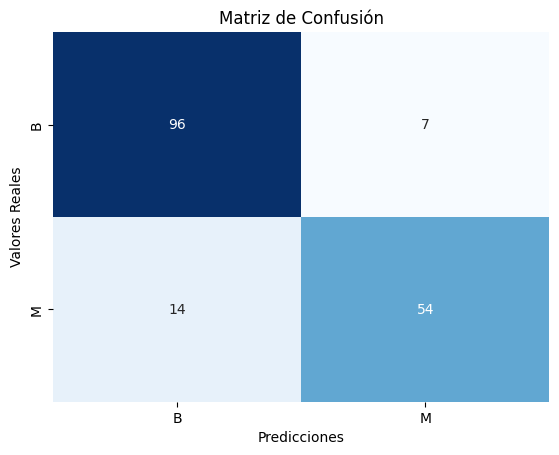

In [ ]:
MLPParameters(5,32)

Epoch 0: train loss: 0.6882656812667847


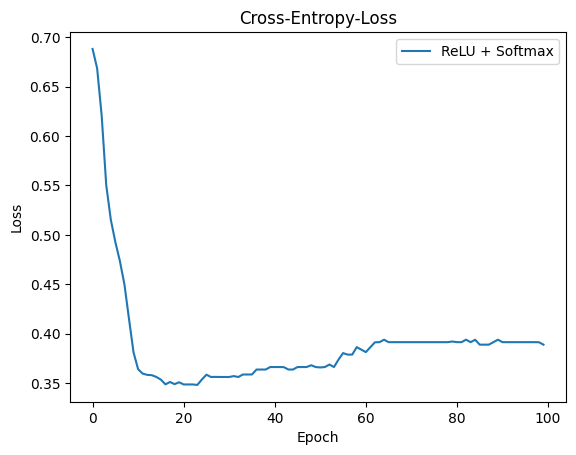

Test Accuracy: 0.8830


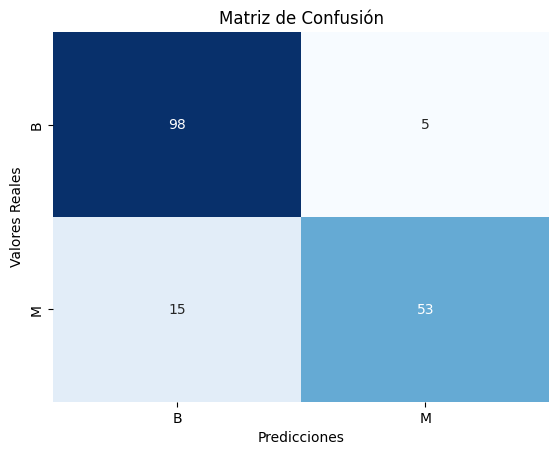

In [ ]:
MLPParameters(5,64)